# 1 特征提取与分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sou = pd.read_csv('train.csv', index_col=0)
pre = pd.read_csv('test.csv', index_col=0)

In [3]:
print(sou.info())
sou

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
pre.info()
pre

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [5]:
sou_index = sou.index
pre_index = pre.index
full = pd.concat([sou, pre])
full

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [6]:
sou.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## 1.1 性别(Sex)

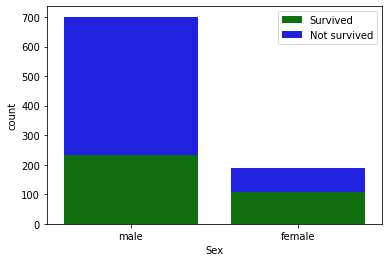

In [7]:
sns.countplot(x='Sex', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Sex', data=sou.query('Survived == 0'), color='blue', bottom=sou.Sex[sou.Survived == 1].value_counts(), label='Not survived')
plt.legend()
plt.show()

In [8]:
full.Sex = full.Sex.map({'male': 1, 'female': -1}).astype('int8')

## 1.2 舱室等级(Pclass)

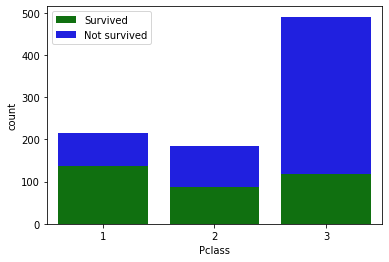

In [9]:
sns.countplot(x='Pclass', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Pclass', data=sou.query('Survived == 0'), color='blue', bottom=sou.Pclass[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()
plt.show()

## 1.3 家庭组成(SibSp, Parch)

In [10]:
sou.SibSp.value_counts(sort=False)

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

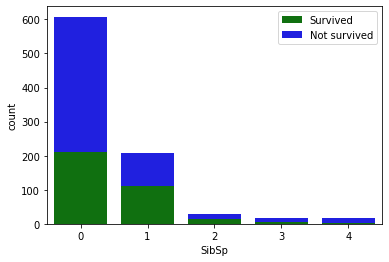

In [11]:
sou_sibsp_u5 = sou[sou.SibSp < 5]   # 数量过少的类型不具统计意义
sns.countplot(x='SibSp', data=sou_sibsp_u5.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='SibSp', data=sou_sibsp_u5.query('Survived == 0'), color='blue', bottom=sou_sibsp_u5.SibSp[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()
plt.show()

In [12]:
sou.Parch.value_counts(sort=False)

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

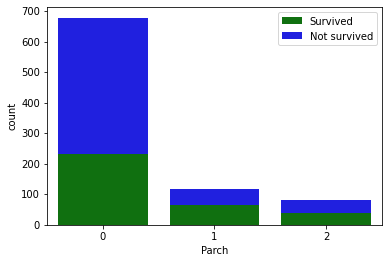

In [13]:
sou_parch_u5 = sou[sou.Parch < 3]   # 数量过少的类型不具统计意义
sns.countplot(x='Parch', data=sou_parch_u5.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Parch', data=sou_parch_u5.query('Survived == 0'), color='blue', bottom=sou_parch_u5.Parch[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()
plt.show()

In [14]:
# 家庭成员总数 Family = SibSp + Parch + self

sou['Family'] = sou.SibSp + sou.Parch + 1
pre['Family'] = pre.SibSp + pre.Parch + 1

sou.Family.value_counts(sort=False)

1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: Family, dtype: int64

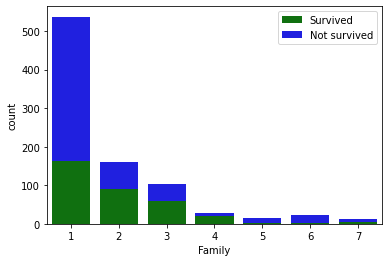

In [15]:
sou_family_u8 = sou[sou.Family < 8]   # 数量过少的类型不具统计意义
sns.countplot(x='Family', data=sou_family_u8.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='Family', data=sou_family_u8.query('Survived == 0'), color='blue', bottom=sou_family_u8.Family[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()
plt.show()

In [16]:
def FamilyType(x):
    if x == 1:
        return 1
    elif x <= 3:
        return 2
    else:
        return 3

sou['FamilyType'] = sou.Family.map(FamilyType)

sou.FamilyType.value_counts(sort=False)

1    537
2    263
3     91
Name: FamilyType, dtype: int64

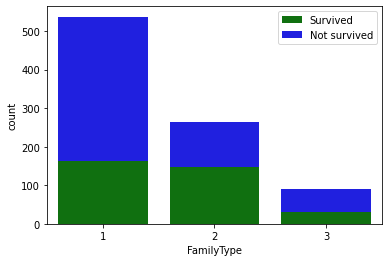

In [17]:
sns.countplot(x='FamilyType', data=sou.query('Survived == 1'), color='green', label='Survived')
sns.countplot(x='FamilyType', data=sou.query('Survived == 0'), color='blue', bottom=sou.FamilyType[sou.Survived == 1].value_counts(sort=False), label='Not survived')
plt.legend()
plt.show()

In [18]:
sou.loc[sou.Family == 1, 'WithFamily'] = 0
sou.loc[sou.Family >= 2, 'WithFamily'] = 1

In [19]:
sou[['Survived', 'SibSp', 'Parch', 'Family', 'FamilyType', 'WithFamily']].corr().Survived

Survived      1.000000
SibSp        -0.035322
Parch         0.081629
Family        0.016639
FamilyType    0.134197
WithFamily    0.203367
Name: Survived, dtype: float64

In [20]:
full.loc[full.SibSp + full.Parch + 1 == 1, 'WithFamily'] = 0
full.loc[full.SibSp + full.Parch + 1 >= 2, 'WithFamily'] = 1
full.WithFamily = full.WithFamily.astype('uint8')
full.drop(columns=['SibSp', 'Parch'], inplace=True)
full

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,WithFamily
PassengerId,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,S,1
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",-1,38.0,PC 17599,71.2833,C85,C,1
3,1.0,3,"Heikkinen, Miss. Laina",-1,26.0,STON/O2. 3101282,7.9250,NaN,S,0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",-1,35.0,113803,53.1000,C123,S,1
5,0.0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",1,NaN,A.5. 3236,8.0500,NaN,S,0
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",-1,39.0,PC 17758,108.9000,C105,C,0
1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,0


## 1.4 年龄(Age)

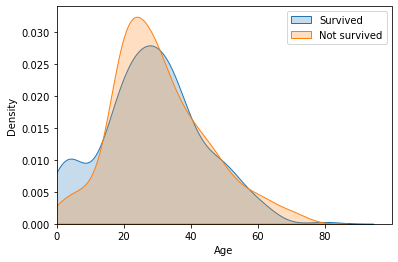

In [21]:
sns.kdeplot(data=sou.Age[sou.Survived == 1], shade=True, label='Survived')
sns.kdeplot(data=sou.Age[sou.Survived == 0], shade=True, label='Not survived')
plt.xlim(left=0)
plt.legend()
plt.show()

In [22]:
full.Age.value_counts()

24.00    47
22.00    43
21.00    41
30.00    40
18.00    39
         ..
76.00     1
22.50     1
74.00     1
80.00     1
0.67      1
Name: Age, Length: 98, dtype: int64

In [23]:
full.Age.fillna(24, inplace=True)

In [24]:
sou.loc[full.Age != 'nan', 'AgeStage'] = (sou.query('Age != "nan"').Age // 10).astype('uint8')

In [25]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# para_grid = {'n_estimators': np.arange(30, 80, 20), 'max_features': np.arange(1, 7, 2), 'min_samples_leaf': np.arange(1, 5)}

# gs = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), para_grid, cv=3)
# gs.fit(sou.query('Age != "nan"').drop(columns=['Survived', 'Name', 'Age', 'AgeStage', 'Cabin']), sou.query('Age != "nan"').AgeStage)

# rfc_age = gs.best_estimator_
# print(gs.best_score_)
# print(gs.best_params_)

In [26]:
# sou.AgeStage.value_counts()

模型预测AgeStage准确率低

In [27]:
sou['Kid'] = (sou.Age <= 15).astype('uint8')

In [28]:
sou['Youth'] = ((sou.Age >= 18) & (sou.Age <= 30)).astype('uint8')

In [29]:
sou.query('Age != "nan"')[['Survived', 'AgeStage', 'Kid', 'Youth']].corr().Survived

Survived    1.000000
AgeStage   -0.073029
Kid         0.136028
Youth      -0.088128
Name: Survived, dtype: float64

In [30]:
full['Kid'] = (full.Age <= 15).astype('uint8')
full['Youth'] = ((full.Age >= 18) & (full.Age <= 30)).astype('uint8')

## 1.5 票价(Fare, Ticket)

In [31]:
full[['Ticket', 'Fare', 'Embarked']].sort_values('Ticket')

,Ticket,Fare,Embarked
PassengerId,,,
505,110152,86.500,S
258,110152,86.500,S
760,110152,86.500,S
586,110413,79.650,S
263,110413,79.650,S
...,...,...,...
906,W.E.P. 5734,61.175,S
93,W.E.P. 5734,61.175,S
220,W/C 14208,10.500,S


存在团体票，多人共用一张票

In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
# 前几位票号与是否存活的协方差
for i in range(1, 8):
    sou['TicketHead'] = sou.Ticket.map(lambda x: x[:i])
    sou['TicketHead'] = LabelEncoder().fit_transform(sou['TicketHead'])
    print(i, sou.corr().Survived.TicketHead)

1 -0.036178039972026635
2 -0.11650137555005768
3 -0.1687942541362634
4 -0.19347495630611067
5 -0.19340874809082542
6 -0.17909315798035835
7 -0.17420990976657752


取特征前4位为新特征

In [34]:
# 相同票号票数
ticket_count = full.Ticket.value_counts()
sou['TicketCount'] = sou.Ticket.apply(lambda x: ticket_count[x])

# 是否团体票
sou['Group'] = (sou.TicketCount > 1).astype('uint8')

# 单人费用 SinFare = Fare / 票数
sou['SinFare'] = sou.Fare / pd.concat([sou, pre]).TicketCount

sou[['Survived', 'TicketCount', 'Group', 'Fare', 'SinFare']].corr().Survived

Survived       1.000000
TicketCount    0.064962
Group          0.252939
Fare           0.257307
SinFare        0.288337
Name: Survived, dtype: float64

提取是否团体票(Group)和票单价(SinFare)为新特征

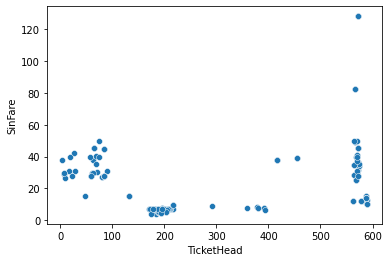

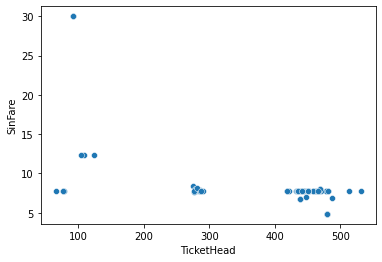

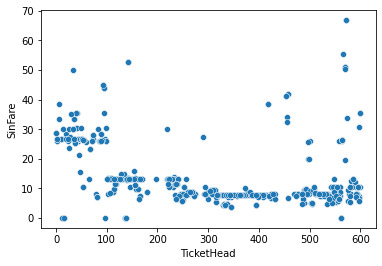

""


In [35]:
def ticket_fare(df):
    sns.scatterplot(x='TicketHead', y='SinFare', data=df)
    # sns.kdeplot(x='TicketHead', y='SinFare', data=df, shade=True)
    plt.show()

sou.groupby('Embarked').apply(ticket_fare)

In [36]:
full['SinFare'] = full.Fare / full.Ticket.apply(lambda x: ticket_count[x])

In [37]:
# Fare的缺失值票号为3701，按370129的单价进行补充
full.loc[full.Ticket == '3701', ['Fare', 'SinFare']] = full.SinFare[full.Ticket == '370129'].values[0]

In [38]:
full['Group'] = (full.Ticket.apply(lambda x: ticket_count[x]) > 1).astype('uint8')
full['TicketHead'] = full.Ticket.map(lambda x: x[:i])
full['TicketHead'] = LabelEncoder().fit_transform(full['TicketHead'])

In [39]:
full.drop(columns='Ticket', inplace=True)

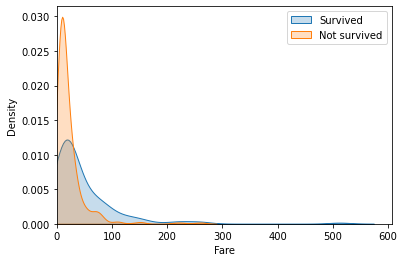

In [40]:
sns.kdeplot(data=full.Fare[full.Survived == 1], shade=True, label='Survived')
sns.kdeplot(data=full.Fare[full.Survived == 0], shade=True, label='Not survived')
plt.xlim(left=0)
plt.legend()
plt.show()

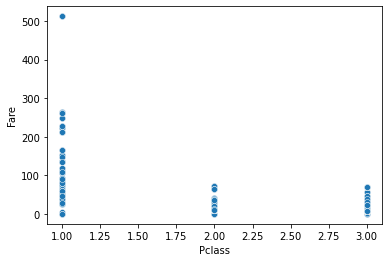

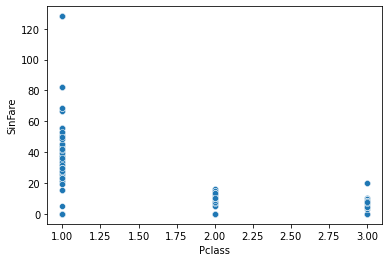

In [41]:
sns.scatterplot(x='Pclass', y='Fare', data=full)
plt.show()

sns.scatterplot(x='Pclass', y='SinFare', data=full)
plt.show()

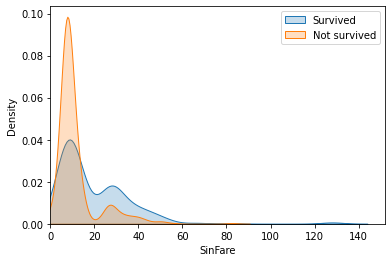

In [42]:
sns.kdeplot(data=full.SinFare[full.Survived == 1], shade=True, label='Survived')
sns.kdeplot(data=full.SinFare[full.Survived == 0], shade=True, label='Not survived')
plt.xlim(left=0)
plt.legend()
plt.show()

## 1.6 港口(Embarked)

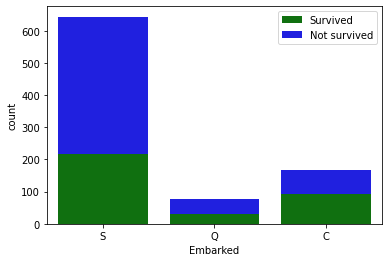

In [43]:
sns.countplot(x='Embarked', data=sou.query('Survived == 1'), order=['S', 'Q', 'C'], color='green', label='Survived')
sns.countplot(x='Embarked', data=sou.query('Survived == 0'), order=['S', 'Q', 'C'], color='blue', bottom=sou.Embarked[sou.Survived == 1].value_counts()[['S', 'Q', 'C']], label='Not survived')
plt.legend()
plt.show()

In [44]:
sou.Embarked = LabelEncoder().fit_transform(sou.Embarked)
sou.corr().Survived.Embarked

-0.16351665142509889

In [45]:
full.Embarked.fillna('S', inplace=True)

In [46]:
full = pd.concat([full.drop(columns='Embarked'), pd.get_dummies(full.Embarked, prefix='Embarked')], axis=1)

## 1.7 姓名(Name)

In [47]:
full.Name.apply(lambda x: x.split(', ')[1].split('.')[0]).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [48]:
def title(x):
    if x == 'Mlle':
        return 'Miss'
    elif x == 'Ms' or x == 'Mme':
        return 'Mrs'
    elif x == 'Don' or x == 'Dona' or x == 'the Countess' or x == 'Jonkheer' or x == 'Sir' or x == 'Lady':
        return 'Noble'
    elif x == 'Dr' or x == 'Rev' or x == 'Col' or x == 'Major' or x == 'Capt':
        return 'Elite'
    else:
        return x

In [49]:
sou['Title'] = sou.Name.apply(lambda x: x.split(', ')[1].split('.')[0])
sou.Title = sou.Title.map(title)

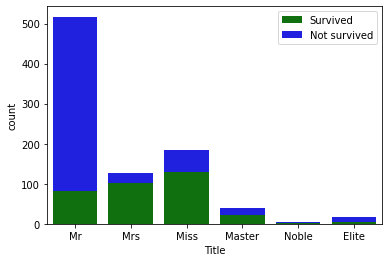

In [50]:
sns.countplot(x='Title', data=sou.query('Survived == 1'), order=sou.Title.unique(), color='green', label='Survived')
sns.countplot(x='Title', data=sou.query('Survived == 0'), order=sou.Title.unique(), color='blue', bottom=sou.Title[sou.Survived == 1].value_counts()[sou.Title.unique()], label='Not survived')
plt.legend()
plt.show()

In [51]:
sou.Title = LabelEncoder().fit_transform(sou.Title)
sou.corr().Survived.Title

-0.037532990367535414

头衔特征影响不大

In [52]:
full.drop(columns='Name', inplace=True)

## 1.8 舱号(Cabin)

In [53]:
sou['CabinType'] = sou.Cabin.fillna('N').map(lambda x: x[0])
sou['WithCabin'] = sou.Cabin.isnull().astype('uint8')

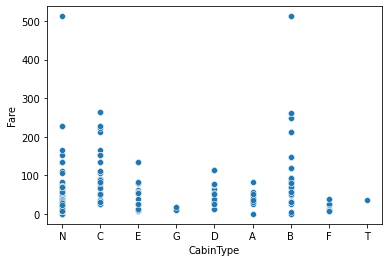

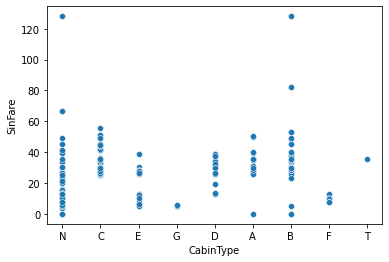

In [54]:
sns.scatterplot(x='CabinType', y='Fare', data=sou)
plt.show()

sns.scatterplot(x='CabinType', y='SinFare', data=sou)
plt.show()

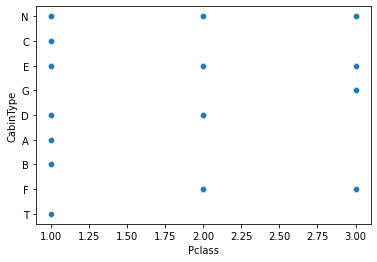

In [55]:
sns.scatterplot(x='Pclass', y='CabinType', data=sou)
plt.show()

Cabin与Pclass、Fare、SinFare关系不大

In [56]:
sou.CabinType = LabelEncoder().fit_transform(sou.CabinType)

In [57]:
sou[['Survived', 'CabinType', 'WithCabin']].corr().Survived

Survived     1.000000
CabinType   -0.295113
WithCabin   -0.316912
Name: Survived, dtype: float64

In [58]:
# 提取是否有舱号为新特征
full['WithCabin'] = full.Cabin.isnull().astype('uint8')
full.drop(columns='Cabin', inplace=True)

## 1.9 特征整理

In [59]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int8   
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   WithFamily  1309 non-null   uint8  
 6   Kid         1309 non-null   uint8  
 7   Youth       1309 non-null   uint8  
 8   SinFare     1309 non-null   float64
 9   Group       1309 non-null   uint8  
 10  TicketHead  1309 non-null   int32  
 11  Embarked_C  1309 non-null   uint8  
 12  Embarked_Q  1309 non-null   uint8  
 13  Embarked_S  1309 non-null   uint8  
 14  WithCabin   1309 non-null   uint8  
dtypes: float64(4), int32(1), int64(1), int8(1), uint8(8)
memory usage: 118.0 KB


In [60]:
full.drop(columns='Fare', inplace=True)

In [61]:
full.Pclass = full.Pclass.astype('uint8')

In [63]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   uint8  
 2   Sex         1309 non-null   int8   
 3   Age         1309 non-null   float64
 4   WithFamily  1309 non-null   uint8  
 5   Kid         1309 non-null   uint8  
 6   Youth       1309 non-null   uint8  
 7   SinFare     1309 non-null   float64
 8   Group       1309 non-null   uint8  
 9   TicketHead  1309 non-null   int32  
 10  Embarked_C  1309 non-null   uint8  
 11  Embarked_Q  1309 non-null   uint8  
 12  Embarked_S  1309 non-null   uint8  
 13  WithCabin   1309 non-null   uint8  
dtypes: float64(3), int32(1), int8(1), uint8(9)
memory usage: 98.8 KB


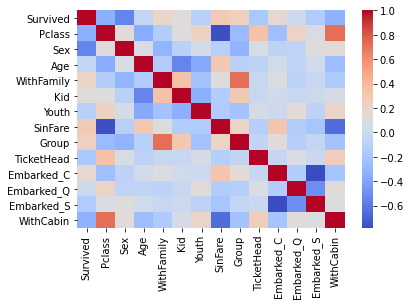

In [64]:
# sns.pairplot(full.loc[sou_index, :])
sns.heatmap(full.loc[sou_index, :].corr(), cmap='coolwarm')  # , annot=True, fmt='.2f'
plt.show()

In [65]:
full.loc[sou_index, :].corr().Survived.abs().sort_values()

Embarked_Q    0.003650
Age           0.052872
Youth         0.113556
Kid           0.136107
Embarked_S    0.149683
Embarked_C    0.168240
TicketHead    0.177362
WithFamily    0.203367
Group         0.252939
SinFare       0.288337
WithCabin     0.316912
Pclass        0.338481
Sex           0.543351
Survived      1.000000
Name: Survived, dtype: float64

In [66]:
sou = full.loc[sou_index, :]
pre = full.loc[pre_index, :]

In [67]:
sou.to_csv('train1.csv')
pre.to_csv('test1.csv')

# 2 特征筛选

In [114]:
sou = pd.read_csv('train1.csv', index_col=0)
pre = pd.read_csv('test1.csv', index_col=0)

sou_index = sou.index
pre_index = pre.index

full = pd.concat([sou, pre])
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   WithFamily  1309 non-null   int64  
 5   Kid         1309 non-null   int64  
 6   Youth       1309 non-null   int64  
 7   SinFare     1309 non-null   float64
 8   Group       1309 non-null   int64  
 9   TicketHead  1309 non-null   int64  
 10  Embarked_C  1309 non-null   int64  
 11  Embarked_Q  1309 non-null   int64  
 12  Embarked_S  1309 non-null   int64  
 13  WithCabin   1309 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 153.4 KB


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [70]:
rfecv = RFECV(estimator=LogisticRegression(), cv=3, n_jobs=-1)
rfecv.fit(sou.drop(columns='Survived'), sou.Survived)
print(rfecv.n_features_)
print(rfecv.ranking_)
print(rfecv.grid_scores_)
print(*zip(sou.columns[1:], rfecv.support_), sep='\n')

11
[1 1 1 1 1 1 2 1 3 1 1 1 1]
[0.78675645 0.78675645 0.79012346 0.77216611 0.78675645 0.78451178
 0.78114478 0.78002245 0.78002245 0.78338945 0.79573513 0.79349046
 0.77665544]
('Pclass', True)
('Sex', True)
('Age', True)
('WithFamily', True)
('Kid', True)
('Youth', True)
('SinFare', False)
('Group', True)
('TicketHead', False)
('Embarked_C', True)
('Embarked_Q', True)
('Embarked_S', True)
('WithCabin', True)


In [71]:
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder

In [72]:
for col in sou.columns[1:]:
    print(col, ks_2samp(sou[col], pre[col]).pvalue)

Pclass 0.9571654941014093
Sex 0.9999999999993855
Age 0.784101898880727
WithFamily 1.0
Kid 0.9999957091753793
Youth 0.33470314558149017
SinFare 0.5488156817290518
Group 0.9999996907322858
TicketHead 0.6946801995730616
Embarked_C 0.3303750185581955
Embarked_Q 0.9959868147519676
Embarked_S 0.0532279287137849
WithCabin 0.9999999999992895


In [115]:
full.drop(columns=['Youth', 'TicketHead', 'Embarked_C', 'Embarked_S', 'Age'], inplace=True)

## 2.1 数据标准化

In [74]:
from sklearn.preprocessing import MinMaxScaler

In [75]:
# from sklearn.preprocessing import StandardScaler

In [116]:
full_mat = MinMaxScaler().fit_transform(full)
# full_mat = StandardScaler().fit_transform(full)

train_X = full_mat[sou_index - 1, 1:]
train_y = full_mat[sou_index - 1, 0].astype('uint8')

test_X = full_mat[pre_index - 1, 1:]

In [78]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [28]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA()
pca.fit(train_X, train_y)

print(pca.n_components_)
print(pca.explained_variance_ratio_)

9
[3.48613198e-01 2.14177347e-01 1.73922447e-01 1.22080344e-01
 6.47612101e-02 4.41753410e-02 2.95279531e-02 2.74216019e-03
 6.03557484e-33]


In [70]:
train_X = PCA(n_components=4).fit_transform(train_X, train_y)

In [117]:
lr = LogisticRegression(random_state=0)
lr.fit(train_X, train_y)

cross_val_score(lr, train_X, train_y, cv=3).mean()

0.7744107744107745

In [102]:
pd.DataFrame({'columns': full.columns[1:], 'coef': list(lr.coef_.T)})

,columns,coef
0,Pclass,[-1.6757703370031456]
1,Sex,[-2.501471716539058]
2,Age,[-1.2693587670584225]
3,WithFamily,[-0.2212568364267733]
4,Kid,[0.793747564772798]
5,Group,[0.11743085222266038]
6,Embarked_Q,[0.31290666889537927]
7,WithCabin,[-0.6772800130287555]


In [81]:
from sklearn.model_selection import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    '''
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel('samples')
        plt.ylabel('score')
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color='b')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color='r')
        plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='train')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='test')

        plt.legend(loc='best')

        # plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

(0.8401118720205989, 0.07779629353323891)

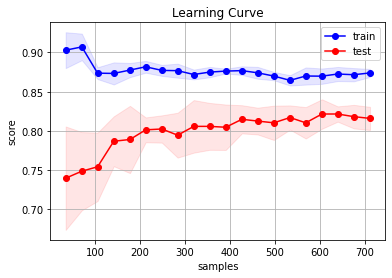

In [125]:
plot_learning_curve(vc, 'Learning Curve', train_X, train_y)

(0.8141753072930029, 0.041956367548534934)

lr: (0.791233991404849, 0.033144800621055404)

svc: (0.8103214698990473, 0.032918340879328434)

rfc: (0.8278436684930084, 0.0777822343076856)

gbc: (0.8566801398033475, 0.14187781453902493)

vc: (0.8401118720205989, 0.07779629353323891)

In [83]:
from sklearn.svm import SVC

In [118]:
para_grid = {'C': np.linspace(0.1, 1, 20), 'gamma': np.linspace(0.1, 1, 20)}
gs = GridSearchCV(SVC(kernel='rbf', random_state=0), para_grid, cv=3)
gs.fit(train_X, train_y)

svc = gs.best_estimator_
print(gs.best_score_)
print(gs.best_params_)

0.8148148148148149
{'C': 0.38421052631578945, 'gamma': 0.8578947368421053}


0.8058361391694725
{'C': 0.8578947368421053, 'gamma': 0.9052631578947369}

0.8024691358024691
{'C': 0.7157894736842105, 'gamma': 0.4789473684210527}

0.8058361391694725
{'C': 0.6210526315789474, 'gamma': 0.9526315789473684}

0.8103254769921436
{'C': 0.8578947368421053, 'gamma': 0.7631578947368421}

0.8170594837261506
{'C': 0.38421052631578945, 'gamma': 0.9052631578947369}

0.8148148148148149
{'C': 0.7157894736842105, 'gamma': 0.6210526315789474}

0.8148148148148149
{'C': 0.4789473684210527, 'gamma': 0.7631578947368421}

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
para_grid = {'n_estimators': np.arange(50, 110, 20), 'max_features': np.arange(5, train_X.shape[1] + 1), 'min_samples_leaf': np.arange(1, 5)}

gs = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), para_grid, cv=3)
gs.fit(train_X, train_y)

rfc = gs.best_estimator_
print(gs.best_score_)
print(gs.best_params_)

0.8148148148148148
{'max_features': 6, 'min_samples_leaf': 4, 'n_estimators': 90}


0.8069584736251403
{'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 50}

0.8058361391694725
{'max_features': 7, 'min_samples_leaf': 4, 'n_estimators': 60}

0.8092031425364757
{'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 90}

0.8125701459034792
{'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 90}

0.8136924803591471
{'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 70}

0.8058361391694726
{'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 70}

0.8215488215488215
{'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 70}

0.8204264870931538
{'max_features': 8, 'min_samples_leaf': 3, 'n_estimators': 70}

0.8114478114478114
{'max_features': 8, 'min_samples_leaf': 4, 'n_estimators': 50}

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

In [122]:
para_grid = {'n_estimators': np.arange(50, 80, 10), 'max_features': np.arange(5, train_X.shape[1] + 1), 'min_samples_leaf': np.arange(1, 5), 'learning_rate': np.linspace(0.05, 0.5, 10)}

gs = GridSearchCV(GradientBoostingClassifier(random_state=0), para_grid, cv=3)
gs.fit(train_X, train_y)

gbc = gs.best_estimator_
print(gs.best_score_)
print(gs.best_params_)

0.8316498316498316
{'learning_rate': 0.5, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 60}


0.8204264870931537
{'learning_rate': 0.2777777777777778, 'max_features': 7, 'min_samples_leaf': 3, 'n_estimators': 50}

0.8170594837261503
{'learning_rate': 0.14444444444444446, 'max_features': 7, 'min_samples_leaf': 4, 'n_estimators': 50}

0.8226711560044894
{'learning_rate': 0.1, 'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 60}

0.8271604938271606
{'learning_rate': 0.45, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 70}

0.819304152637486
{'learning_rate': 0.25, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 70}

0.8316498316498318
{'learning_rate': 0.25, 'max_features': 7, 'min_samples_leaf': 4, 'n_estimators': 50}

0.8350168350168351
{'learning_rate': 0.25, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 50}

0.8327721661054994
{'learning_rate': 0.2, 'max_features': 7, 'min_samples_leaf': 4, 'n_estimators': 50}

In [91]:
from sklearn.ensemble import VotingClassifier

In [124]:
vc = VotingClassifier([('svc', svc), ('rfc', rfc), ('gbc', gbc)])
vc.fit(train_X, train_y)

cross_val_score(vc, train_X, train_y).mean()

0.8136965664427844

0.8069801016885318

0.8035842068922229

0.811461929571276

0.8237963718536188

0.8125729709371665

0.8181909484652564

0.8260498399347185

0.8181783943255289

In [126]:
pre_sur = pre[['Survived']]
pre_sur.Survived = svc.predict(test_X)
pre_sur.to_csv('submission/submission_SVC3.csv')

In [125]:
pd.concat([sou, pre]).Age.value_counts() / pd.concat([sou, pre]).Age.value_counts().sum()

24.00    0.044933
22.00    0.041109
21.00    0.039197
30.00    0.038241
18.00    0.037285
           ...   
76.00    0.000956
22.50    0.000956
74.00    0.000956
80.00    0.000956
0.67     0.000956
Name: Age, Length: 98, dtype: float64